In [1]:
import os
import cv2
import glob
import random
import numpy as np
import imgaug as ia
import pandas as pd
import tensorflow as tf
from progressbar import * #进度条
from natsort import natsorted
import matplotlib.pyplot as plt
from imgaug import augmenters as iaa
from imgaug import parameters as iap
from skimage.transform import resize
from skimage.io import imread, imsave
from sklearn.metrics import confusion_matrix
from skimage import transform, filters, exposure

os.environ['CUDA_VISIBLE_DEVICES']='3'
%matplotlib inline

/home/lhw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lhw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
label2int = {'airplane':0, 'automobile':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}
int2lable = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

In [3]:
#由于数据集较大，采用tensorflow自带的TFRecord进行读取
def Trainset2TFRecord2(train_tfrecords_path, val_tfrecords_path, ratio=0.9, data_path='data'):
    files = natsorted(glob.glob(data_path + '/train/*'))
    total = len(files)
    train_num = int(total*ratio)
    val_num = total-train_num
    if (os.path.exists(train_tfrecords_path) and os.path.exists(val_tfrecords_path)):
        print('data have already processed')
        return train_num, val_num
    
    writer_train = tf.python_io.TFRecordWriter(train_tfrecords_path)
    writer_val = tf.python_io.TFRecordWriter(val_tfrecords_path)
    
    labels = pd.read_csv(data_path + '/trainLabels.csv')
    
    pbar = ProgressBar().start()
    for i, file_path in enumerate(files):
        pbar.update(int((i / (total - 1)) * 100))#进度条
        time.sleep(0.01)

        img_raw = tf.gfile.FastGFile(file_path, 'rb').read()
        label = label2int[labels.loc[i].label]

        example = tf.train.Example(features=tf.train.Features(feature={
            'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
            'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
        }))
        if i < train_num:
            writer_train.write(example.SerializeToString())
        else:
            writer_val.write(example.SerializeToString())
    writer_train.close()
    writer_val.close()
    pbar.finish()
    
    return train_num, val_num
def TFRecord2TrainData2(train_tfrecords_path, num_class, batch_size, num_epochs, shuffle=True):
    filename_queue = tf.train.string_input_producer([train_tfrecords_path], num_epochs=num_epochs)
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)   #返回文件名和文件
    features = tf.parse_single_example(serialized_example,
                                   features={
                                       'img_raw' : tf.FixedLenFeature([], tf.string),
                                       'label': tf.FixedLenFeature([], tf.int64)
                                   })
    img = tf.image.decode_png(features['img_raw'])  # 与方式一的不同点在于需要用decode_png/decode_jpeg解码
                                                    # output an RGB image. [height, width, channels]
    img = tf.reshape(img, [32, 32, 3])
    img = tf.image.resize_images(img, [224, 224])
    label = tf.cast(features['label'], tf.int32)
    label = tf.one_hot(label,num_class,1,0)
    if shuffle==True:
        img_batch, label_batch = tf.train.shuffle_batch([img, label], batch_size=batch_size,\
                                                        capacity=500 + 3 * batch_size, min_after_dequeue=500)
    else:
        img_batch, label_batch = tf.train.batch([img, label], batch_size=batch_size, capacity= 3 * batch_size)
    return img_batch, label_batch

In [4]:
train_tfrecords_path = 'data/train.tfrecord'
val_tfrecords_path = 'data/val.tfrecord'
train_num, val_num = Trainset2TFRecord2(train_tfrecords_path, val_tfrecords_path)
print(train_num, val_num)

data have already processed
45000 5000


In [23]:
#解码并查看效果
#img,label = TFRecord2TrainData(train_tfrecords_path, 10)
#img_batch, label_batch = tf.train.shuffle_batch([img, label], batch_size=500, capacity=50000, min_after_dequeue=1000, num_threads=1)
#capacity是队列的最大容量, min_after_dequeue是dequeue后最小的队列大小,这个代表队列中的元素大于它的时候就输出乱的顺序的batch
#num_threads是进行队列操作的线程数。
img_train_batch, label_train_batch = TFRecord2TrainData2(train_tfrecords_path, 10, 128, 5)
img_val_batch, label_val_batch = TFRecord2TrainData2(val_tfrecords_path, 10, 128, 5)#10类 batch_size=128, epoch = 5
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    #先产生！个看下效果
    '''
    for epoch in range(10):
        try:
            while not coord.should_stop():
                img_, label_ = sess.run([img_batch, label_batch]) 
                print(epoch)
        except tf.errors.OutOfRangeError:
            print("done")
        finally:
            coord.request_stop()
        coord.join(threads)
    ''' 
    #验证集上测试
    try:
        train_total_batch = int(train_num/128)
        val_total_bath = int(val_num/128)
        epoch = 0
        while not coord.should_stop():#使用 coord.should_stop()来查询是否应该终止所有线程
            #开始一个epoch的训练
            train_begin = 0
            val_begin = 0
            for i in range(train_total_batch):
                img_, label_ = sess.run([img_train_batch, label_train_batch]) 
                if train_begin == 0:
                    print("train")
                    print(epoch, img_.shape)
                    train_begin = 1
            for i in range(val_total_bath):
                img_, label_ = sess.run([img_val_batch, label_val_batch]) 
                if val_begin == 0:
                    print("val")
                    print(epoch, img_.shape)
                    val_begin = 1
            epoch+=1
    except tf.errors.OutOfRangeError:
        print("done")
    finally:       
        coord.request_stop()#使用coord.request_stop()来发出终止所有线程的命令
        coord.join(threads)#使用coord.join(threads)把线程加入主线程，等待threads结束。
    '''
    for i in range(10): #产生10个batch
        img_, label_ = sess.run([img_batch, label_batch])#每次输出queue中的一个batch
        plt.subplot(2, 5, i+1)
        label = int2lable[np.argmax(label_, axis=1)[0]]
        plt.title(label)
        plt.imshow(img_[0].astype('uint8'))
        i += 1
    plt.show()
    coord.request_stop()
    coord.join(threads)
    '''

train
0 (128, 224, 224, 3)
val
0 (128, 224, 224, 3)
train
1 (128, 224, 224, 3)
val
1 (128, 224, 224, 3)
train
2 (128, 224, 224, 3)
val
2 (128, 224, 224, 3)
train
3 (128, 224, 224, 3)
val
3 (128, 224, 224, 3)
train
4 (128, 224, 224, 3)
val
4 (128, 224, 224, 3)
train
5 (128, 224, 224, 3)
done


In [52]:
#效果证明还存在bug 效果不好
def augment(images, labels,
            resize=None, # (width, height) tuple or None
            horizontal_flip=False,
            vertical_flip=False,
            rotate=0, # Maximum rotation angle in degrees
            crop_probability=0, # How often we do crops
            crop_min_percent=0.6, # Minimum linear dimension of a crop
            crop_max_percent=1.,  # Maximum linear dimension of a crop
            mixup=0):  # Mixup coeffecient, see https://arxiv.org/abs/1710.09412.pdf
    if resize is not None:
        images = tf.image.resize_bilinear(images, resize)
  
      # My experiments showed that casting on GPU improves training performance

    #if images.dtype != tf.float32:
    if images.dtype != 'float32':
        images = tf.image.convert_image_dtype(images, dtype=tf.float32)
        images = tf.subtract(images, 0.5)
        images = tf.multiply(images, 2.0)
        
    if labels.dtype != 'float32':
        #labels = labels.astype(dtype = np.float32)
        labels = tf.to_float(labels)

    with tf.name_scope('augmentation'):
        shp = tf.shape(images)
        batch_size, height, width = shp[0], shp[1], shp[2]
        width = tf.cast(width, tf.float32)
        height = tf.cast(height, tf.float32)

        # The list of affine transformations that our image will go under.
        # Every element is Nx8 tensor, where N is a batch size.
        transforms = []
        identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
        if horizontal_flip:
            coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), 0.5)
            flip_transform = tf.convert_to_tensor(
                  [-1., 0., width, 0., 1., 0., 0., 0.], dtype=tf.float32)
            transforms.append(tf.where(coin,tf.tile(tf.expand_dims(flip_transform, 0), [batch_size, 1]),
                       tf.tile(tf.expand_dims(identity, 0), [batch_size, 1])))

        if vertical_flip:
            coin = tf.less(tf.random_uniform([batch_size], 0, 1.0), 0.5)
            flip_transform = tf.convert_to_tensor([1, 0, 0, 0, -1, height, 0, 0], dtype=tf.float32)
            transforms.append(tf.where(coin,tf.tile(tf.expand_dims(flip_transform, 0), [batch_size, 1]),\
                                       tf.tile(tf.expand_dims(identity, 0), [batch_size, 1])))

        if rotate > 0:
            angle_rad = rotate / 180 * math.pi
            angles = tf.random_uniform([batch_size], -angle_rad, angle_rad)
            transforms.append(tf.contrib.image.angles_to_projective_transforms(angles, height, width))

        if crop_probability > 0:
            crop_pct = tf.random_uniform([batch_size], crop_min_percent,crop_max_percent)
            left = tf.random_uniform([batch_size], 0, width * (1 - crop_pct))
            top = tf.random_uniform([batch_size], 0, height * (1 - crop_pct))
            crop_transform = tf.stack([
                crop_pct,
                tf.zeros([batch_size]), top,
                tf.zeros([batch_size]), crop_pct, left,
                tf.zeros([batch_size]),
                tf.zeros([batch_size])
          ], 1)

            coin = tf.less(
              tf.random_uniform([batch_size], 0, 1.0), crop_probability)
            transforms.append(
              tf.where(coin, crop_transform,
                       tf.tile(tf.expand_dims(identity, 0), [batch_size, 1])))

        if transforms:
            images = tf.contrib.image.transform(
              images,
              tf.contrib.image.compose_transforms(*transforms),
              interpolation='BILINEAR') # or 'NEAREST'

        def cshift(values): # Circular shift in batch dimension
            return tf.concat([values[-1:, ...], values[:-1, ...]], 0)

        if mixup > 0:
            mixup = 1.0 * mixup # Convert to float, as tf.distributions.Beta requires floats.
            beta = tf.distributions.Beta(mixup, mixup)
            lam = beta.sample(batch_size)
            ll = tf.expand_dims(tf.expand_dims(tf.expand_dims(lam, -1), -1), -1)
            images = ll * images + (1 - ll) * cshift(images)
            labels = lam * labels + (1 - lam) * cshift(labels)

    return images, labels

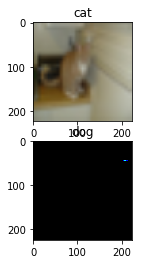

In [55]:
#查看扩充数据后的效果
x_data = images = tf.placeholder(tf.uint8, shape=(None, None, None, 3))
y_data = tf.placeholder(tf.uint8, shape=(None))

img_tensor, label_tensor = augment(x_data, y_data, horizontal_flip=True, rotate=15, crop_probability=0.8, mixup=4)

batch_size = 1

img_train_batch, label_train_batch = TFRecord2TrainData2(train_tfrecords_path, 10, batch_size, 1)
img_val_batch, label_val_batch = TFRecord2TrainData2(val_tfrecords_path, 10, batch_size, 1)#10类 batch_size=128, epoch = 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)

    for i in range(1): #产生1个batch
        img_batch, label_batch = sess.run([img_train_batch, label_train_batch])#每次输出queue中的一个batch
        for j in range(batch_size):
            plt.subplot(2, batch_size, j+1)
            label = int2lable[np.argmax(label_, axis=1)[j]]
            plt.title(label)
            plt.imshow(img_[j].astype('uint8'))
        #扩增后的数据
        img_aug, label_aug = sess.run([img_tensor, label_tensor], feed_dict={x_data:img_batch, y_data:label_batch})
        for j in range(batch_size):
            plt.subplot(2, batch_size, j+batch_size+1)
            label = int2lable[np.argmax(label_aug, axis=1)[j]]
            plt.title(label)
            plt.imshow(img_aug[j].astype('uint8'))
    plt.show()
    coord.request_stop()
    coord.join(threads)

In [57]:
def batch_augment(data):
    seq = iaa.Sequential([
        iaa.Crop(percent=0.01), # # 从每侧裁剪图像0到16px（随机选择）
        iaa.Fliplr(0.5), # 水平翻转图像 括号内为Probability of each image to get flipped.
        iaa.Flipud(0.5), #上下翻转
        #iaa.GaussianBlur(sigma=(0, 3.0)),  # 使用0到3.0的sigma模糊图像
        iaa.Affine(scale=(0.7, 1.3), translate_percent=0.01, rotate=iap.Normal(-20, 20)),#旋转
        iaa.Multiply(iap.Positive(iap.Normal(0.0, 0.1)) + 1.0),#明暗变化
        #iaa.AddElementwise(iap.Discretize((iap.Beta(0.5, 0.5) * 2 - 1.0) * 64))
        #iaa.AdditiveGaussianNoise(scale=(0,  0.05*255)),
        #iaa.Sharpen(alpha=0.5),
        #iaa.Scale((0.5, 1.5))
    ],random_order=True)#每个batch中的Augmenters顺序不一样
    x_batch = seq.augment_images(data)
    return x_batch

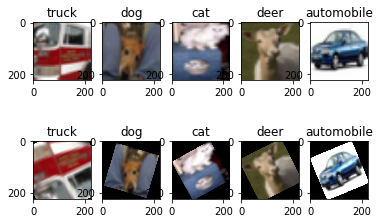

In [63]:
batch_size = 5
img_train_batch, label_train_batch = TFRecord2TrainData2(train_tfrecords_path, 10, batch_size, 1)
img_val_batch, label_val_batch = TFRecord2TrainData2(val_tfrecords_path, 10, batch_size, 1)#10类 batch_size=128, epoch = 1
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    for i in range(1) : #产生1个batch
        img_batch, label_batch = sess.run([img_train_batch, label_train_batch])#每次输出queue中的一个batch
        for j in range(batch_size):
            plt.subplot(2, batch_size, j+1)
            label = int2lable[np.argmax(label_batch, axis=1)[j]]
            plt.title(label)
            plt.imshow(img_batch[j].astype('uint8'))
        #扩增后的数据
        '''
        for j in range(batch_size):
            plt.subplot(2, batch_size, j+batch_size+1)
            label = int2lable[np.argmax(label_batch, axis=1)[j]]
            plt.title(label)
            plt.imshow(img_batch[j].astype('uint8'))
        '''
        img_aug = batch_augment(img_batch)
        for j in range(batch_size):
            plt.subplot(2, batch_size, j+batch_size+1)
            label = int2lable[np.argmax(label_batch, axis=1)[j]]
            plt.title(label)
            plt.imshow(img_aug[j].astype('uint8'))
        
    plt.show()
    coord.request_stop()
    coord.join(threads)

In [ ]:
### 查看预训练模型中的参数 ###
ckpt_path = './model/vgg19/mode.ckpt'
pre_model_path = 'model/vgg19/vgg19.npy'
pre_model = np.load(pre_model_path, encoding = "bytes").item()
layers = list(pre_model.keys())#将dict转换为list  层的名称
#layer_1 = pre_model[layers[0]] #第一层中内容
#layer_1_w =  pre_model[layers[0]][0]  #第一层的权重
print(layers)
layer_1_0 =  pre_model[layers[0]][1] #第一层的偏差
print(pre_model[layers[0]][0].shape) #第一层权重的形状 (3, 3, 3, 64)
print(pre_model[layers[0]][1].shape) #第一层的偏差的形状 (64,)

In [6]:
class VGG_19:
    def __init__(self, x, classname, is_training, weights=None, sess=None):
        self.parameters = []
        self.vgg_mean = [103.939, 116.779, 123.68]
        self.build_model(x, classname, is_training)
        self.skip = ['fc7', 'fc8'] #需要重新训练的层
        self.probs = self.fc8
        if weights is not None and sess is not None:
            self.load_weights(weights, sess)
    
    def maxpool(self,name,input_data, trainable):
        out = tf.nn.max_pool(input_data,[1,2,2,1],[1,2,2,1],padding="SAME",name=name)
        return out
    
    def conv(self,name, input_data, out_channel, trainable):
        in_channel = input_data.get_shape()[-1]
        with tf.variable_scope(name):
            kernel = tf.get_variable("weights", [3, 3, in_channel, out_channel], dtype=tf.float32,trainable=False)
            biases = tf.get_variable("biases", [out_channel], dtype=tf.float32,trainable=False)
            conv_res = tf.nn.conv2d(input_data, kernel, [1, 1, 1, 1], padding="SAME")
            res = tf.nn.bias_add(conv_res, biases)
            #norm = tf.layers.batch_normalization(res, center=True, scale=True, training=trainable)
            out = tf.nn.relu(res, name=name)
        self.parameters += [kernel, biases]
        return out
    
    def fc(self,name,input_data,out_channel, relu_flag = True,trainable = True):
        shape = input_data.get_shape().as_list()
        if len(shape) == 4:
            size = shape[-1] * shape[-2] * shape[-3]
        else:size = shape[1]
        input_data_flat = tf.reshape(input_data,[-1,size])
        with tf.variable_scope(name):
            weights = tf.get_variable(name="weights",shape=[size,out_channel],dtype=tf.float32,trainable = trainable)
            biases = tf.get_variable(name="biases",shape=[out_channel],dtype=tf.float32,trainable = trainable)
            res = tf.matmul(input_data_flat,weights)
            if relu_flag == True:
                #norm = tf.layers.batch_normalization(res, center=True, scale=True, training=trainable)
                out = tf.nn.relu(tf.nn.bias_add(res,biases))
            else:
                out = res
        self.parameters += [weights, biases]
        return out
    
    def build_model(self, x, classnum, is_training):
        # Preprocess
        # Convert RGB to BGR opencv 读取的为BGR格式，所以不用转换
        #red, green, blue = tf.split(axis=3, num_or_size_splits=3, value=self.rgb)#RGB格式
        blue,  green, red = tf.split(axis=3, num_or_size_splits=3, value=x)#张量被切为三份
        self.bgr = tf.concat(axis=3, values=[blue - self.vgg_mean[0], green - self.vgg_mean[1],red - self.vgg_mean[2]])
        
        # Block 1
        #对于每个卷积层和全连接层中，不需要训练的权重全部被设置为trainable=False
        self.conv1_1 = self.conv("conv1_1",self.bgr,64,trainable=True)
        self.conv1_2 = self.conv("conv1_2",self.conv1_1,64,trainable=True)
        self.pool1 = self.maxpool("pool1",self.conv1_2,trainable=True)
        
        # Block 2
        self.conv2_1 = self.conv("conv2_1",self.pool1,128,trainable=True)
        self.conv2_2 = self.conv("conv2_2",self.conv2_1,128,trainable=True)
        self.pool2 = self.maxpool("pool2",self.conv2_2,trainable=True)  
        
        # Block 3
        self.conv3_1 = self.conv("conv3_1",self.pool2,256,trainable=True)
        self.conv3_2 = self.conv("conv3_2",self.conv3_1,256,trainable=True)
        self.conv3_3 = self.conv("conv3_3",self.conv3_2,256,trainable=True)
        self.conv3_4 = self.conv("conv3_4",self.conv3_3,256,trainable=True)
        self.pool3 = self.maxpool("pool3",self.conv3_4,trainable=True)  
        
        # Block 4
        self.conv4_1 = self.conv("conv4_1",self.pool3,512,trainable=True)
        self.conv4_2 = self.conv("conv4_2",self.conv4_1,512,trainable=True)
        self.conv4_3 = self.conv("conv4_3",self.conv4_2,512,trainable=True)
        self.conv4_4 = self.conv("conv4_4",self.conv4_3,512,trainable=True)
        self.pool4 = self.maxpool("pool4",self.conv4_4,trainable=True)
        
        # Block 5
        self.conv5_1 = self.conv("conv5_1",self.pool4,512,trainable=True)
        self.conv5_2 = self.conv("conv5_2",self.conv5_1,512,trainable=True)
        self.conv5_3 = self.conv("conv5_3",self.conv5_2,512,trainable=True)
        self.conv5_4 = self.conv("conv5_4",self.conv5_3,512,trainable=True)
        self.pool5 = self.maxpool("pool5",self.conv5_4,trainable=True)
        
        # model modification for cifar-10
        self.fc6 = self.fc("fc6", self.pool5, 4096, relu_flag=True, trainable=True)
        if is_training == True:
            self.fc6 = tf.layers.dropout(self.fc6, 0.5)
        self.fc7 = self.fc("fc7", self.fc6, 4096, relu_flag=True, trainable=True)
        if is_training == True:
            self.fc7 = tf.layers.dropout(self.fc7, 0.5)
        self.fc8 = self.fc("fc8", self.fc7, classnum, relu_flag=False, trainable=True)
    
    def load_npz_weights(self, weight_file, sess):
        weights = np.load(weight_file)
        keys = sorted(weights.keys())
        for i, k in enumerate(keys):
            if i not in [36,37]:#最后一层不参加训练
                sess.run(self.parameters[i].assign(weights[k]))
        print("-----------Load weights done!---------------")
    def load_npy_weights(self, weight_file, sess):
        weights = np.load(weight_file, encoding = "bytes").item()
        #for layers in model
        for name in weights:
            if name not in self.skip:
                with tf.variable_scope(name, reuse = True):
                    for p in weights[name]:
                        if len(p.shape) == 1:
                            #bias 只有一维
                            sess.run(tf.get_variable('biases', trainable = True).assign(p))
                        else:
                            #weights
                            sess.run(tf.get_variable('weights', trainable = True).assign(p)) 

In [66]:
### 用tfrecord训练 ###
#训练参数
BATCH_SIZE = 100
EPOCHS = 500             #迭代次数
EARLY_STOP_PATIENCE = 10 #控制early stopping的参数
NUM_CLASSS = 10

tf.reset_default_graph()
x_data = tf.placeholder(tf.float32, [None, 224, 224, 3])
y_data = tf.placeholder(tf.float32, [None, 10])
is_training = tf.placeholder(tf.bool)
ckpt_path = './model/vgg/mode.ckpt'

vgg = VGG_19(x_data, 10, is_training)
predict = vgg.probs

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=predict, labels=y_data))
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):#批归一化层
    train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)
acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predict, 1), tf.argmax(y_data, 1)), tf.float32))

#从TFrecord中导入数据队列
#img_batch,label_batch = TFRecord2TrainData2(train_tfrecords_path, NUM_CLASSS, BATCH_SIZE, EPOCHS)#每次读入1 epoch
img_train_batch, label_train_batch = TFRecord2TrainData2(train_tfrecords_path, NUM_CLASSS, BATCH_SIZE, EPOCHS)
img_val_batch, label_val_batch = TFRecord2TrainData2(val_tfrecords_path, NUM_CLASSS, BATCH_SIZE, EPOCHS)
#img_batch, label_batch = tf.train.shuffle_batch([img, label], batch_size=BATCH_SIZE, capacity=50000, min_after_dequeue=500, num_threads=1)

saver = tf.train.Saver()
with tf.Session() as sess:
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess.run(init_op)
    vgg.load_npy_weights(pre_model_path, sess)

    best_acc = 0
    current_epoch = 0

    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    
    try:
        train_total_batch = int(train_num/BATCH_SIZE)
        val_total_bath = int(val_num/BATCH_SIZE)
        epoch = 0
        while not coord.should_stop() and epoch < EPOCHS:
            #开始一个epoch的训练
            train_loss_sum = 0
            for i in range(train_total_batch):
                x_train_batch, y_train_batch = sess.run([img_train_batch, label_train_batch])
                _, train_loss_epoch = sess.run([train_step, loss], \
                             feed_dict={x_data:x_train_batch, y_data:y_train_batch, is_training:True})
                #数据扩充
                x_batch_aug = batch_augment(x_train_batch)
                _, loss_aug_epoch = sess.run([train_step, loss], \
                                       feed_dict={x_data:x_batch_aug, y_data:y_train_batch, is_training:True})
                train_loss_sum = train_loss_sum + (train_loss_epoch + loss_aug_epoch)/2
            train_loss = train_loss_sum/train_total_batch 
            #每经过一个epoch，在验证集上进行验证
            val_acc_sum = 0
            val_loss_sum = 0
            for j in range(val_total_bath):
                x_val_batch, y_val_batch = sess.run([img_val_batch, label_val_batch])
                val_loss_epoch, val_acc_epoch = sess.run([loss, acc], feed_dict={x_data:x_val_batch, y_data:y_val_batch, is_training:False})
                val_acc_sum+=val_acc_epoch
                val_loss_sum+=val_loss_epoch
            val_loss = val_loss_sum/val_total_bath
            val_acc = val_acc_sum/val_total_bath
            print("epoch %d train loss is %f validataion loss is %f accuracy is %f" % (epoch, train_loss, val_loss, val_acc))
           
            if best_acc < val_acc:
                print('----  epoch %d current best_acc is %f' % (epoch, val_acc))
                best_acc = val_acc
                current_epoch = epoch
                saver.save(sess, ckpt_path)
            elif (epoch - current_epoch) >= EARLY_STOP_PATIENCE:
                print('early stoping')
                break  
                
            epoch += 1
    except tf.errors.OutOfRangeError:
        print('done')
    finally:
        coord.request_stop()
        coord.join(threads)

epoch 0 train loss is 1.904445 validataion loss is 0.469503 accuracy is 0.834200
----  epoch 0 current best_acc is 0.834200
epoch 1 train loss is 0.620309 validataion loss is 0.480060 accuracy is 0.854000
----  epoch 1 current best_acc is 0.854000
epoch 2 train loss is 0.546100 validataion loss is 0.491614 accuracy is 0.853600
epoch 3 train loss is 0.515362 validataion loss is 0.555238 accuracy is 0.863800
----  epoch 3 current best_acc is 0.863800
epoch 4 train loss is 0.487749 validataion loss is 0.574889 accuracy is 0.862400
epoch 5 train loss is 0.468680 validataion loss is 0.550385 accuracy is 0.864000
----  epoch 5 current best_acc is 0.864000
epoch 6 train loss is 0.453603 validataion loss is 0.625996 accuracy is 0.867400
----  epoch 6 current best_acc is 0.867400
epoch 7 train loss is 0.445794 validataion loss is 0.626607 accuracy is 0.859800
epoch 8 train loss is 0.441115 validataion loss is 0.708388 accuracy is 0.852200
epoch 9 train loss is 0.426377 validataion loss is 0.640

In [67]:
### 计算混淆矩阵  ###
def list_flatten(a):
    b = []
    for each in a:
        if not isinstance(each, list):
            b.append(each)
        else:
            b.extend(list_flatten(each))
    return b  
def testModel(ckpt_path):
    tf.reset_default_graph()#mo
    x_data = tf.placeholder(tf.float32, [None, 224, 224, 3])
    y_data = tf.placeholder(tf.float32, [None, 10])
    is_training = tf.placeholder(tf.bool)
    vgg = VGG_19(x_data, 10, is_training)
    predict = vgg.probs
    
    accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(predict, 1), tf.argmax(y_data, 1)), tf.float32))
    
    img_batch,label_batch = TFRecord2TrainData2(val_tfrecords_path, 10, 128, 1, False)#每次读入1 epoch
    
    saver = tf.train.Saver() 
    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())
        saver.restore(sess, ckpt_path)
        
        acc = []
        y_pred = []
        y_true = []
        
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)   
        try:
            while not coord.should_stop():
                x_batch, y_batch = sess.run([img_batch, label_batch])
                y_hat_batch = predict.eval({x_data: x_batch, is_training:False})
                y_pred_batch = np.argmax(y_hat_batch, axis=1)
                y_pred.append(y_pred_batch.tolist())
                y_true_batch = np.argmax(y_batch, axis=1)
                y_true.append(y_true_batch.tolist())
                
                acc_batch = accuracy.eval(feed_dict={x_data:x_batch, y_data:y_batch, is_training:False})
                acc.append(acc_batch.tolist())        
        
        except tf.errors.OutOfRangeError:
            print('done')
        finally:
            coord.request_stop()
            coord.join(threads)
            
        y_true_array = np.array(list_flatten(y_true))
        y_pred_array = np.array(list_flatten(y_pred))
        cm = confusion_matrix(y_true_array, y_pred_array)
        print(cm)
        print(acc)

In [68]:
ckpt_path = './model/vgg19/mode.ckpt'
testModel(ckpt_path)

INFO:tensorflow:Restoring parameters from ./model/vgg19/mode.ckpt
done
[[418   6  29  14   8   0   0   2  12   2]
 [  3 456   0   3   2   1   0   0   9  11]
 [ 12   1 433   4  11   3   8   5   1   0]
 [ 20   7  36 391   7  33   8  11   5   1]
 [ 13   0  77  16 332   3   7  22   4   1]
 [ 13   4  48  82  10 338   5  27   2   0]
 [  5   5  30  34   3   2 403   1   2   2]
 [  3   0  14   7  18   6   2 430   5   0]
 [ 66  17   3   5   8   0   2   2 417  12]
 [  3  27   1   1   0   0   0   0   4 475]]
[0.8203125, 0.8046875, 0.828125, 0.75, 0.828125, 0.828125, 0.890625, 0.7890625, 0.796875, 0.8046875, 0.8515625, 0.78125, 0.8203125, 0.8671875, 0.8359375, 0.8125, 0.796875, 0.8125, 0.859375, 0.8203125, 0.8828125, 0.8125, 0.734375, 0.8515625, 0.875, 0.828125, 0.7890625, 0.828125, 0.8671875, 0.8203125, 0.8515625, 0.84375, 0.7734375, 0.859375, 0.7734375, 0.8125, 0.7578125, 0.8203125, 0.796875]


In [9]:
### 测试集数据的读取  ###
#由于数据集较大，采用tensorflow自带的TFRecord进行读取
def testset2TFRecord(test_tfrecords_path, data_path='data'):
    files = natsorted(glob.glob(data_path + '/test/*'))
    total = len(files)
    if (os.path.exists(test_tfrecords_path)):
        print('data have already processed')
        return total
    writer = tf.python_io.TFRecordWriter(test_tfrecords_path)

    pbar = ProgressBar().start()
    for i, file_path in enumerate(files):
        pbar.update(int((i / (total - 1)) * 100))#进度条
        time.sleep(0.01)
        
        img_raw = tf.gfile.FastGFile(file_path, 'rb').read()
        idx = i+1
        example = tf.train.Example(features=tf.train.Features(feature={
            'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
            'idx': tf.train.Feature(int64_list=tf.train.Int64List(value=[idx]))
        }))
        
        writer.write(example.SerializeToString())
    writer.close()
    pbar.finish()
def TFRecord2TestData(test_tfrecords_path, _batch_size=128):
    filename_queue = tf.train.string_input_producer([test_tfrecords_path], num_epochs=1)
    #第二个参数num_epochs: 可选参数，是一个整数值，代表迭代的次数，
    #如果设置 num_epochs=None,生成器可以无限次遍历tensor列表，如果设置为 num_epochs=N，生成器只能遍历tensor列表N次。
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)   #返回文件名和文件
    features = tf.parse_single_example(serialized_example,
                                   features={
                                       'img_raw' : tf.FixedLenFeature([], tf.string),
                                       'idx': tf.FixedLenFeature([], tf.int64)
                                   })
    idx = tf.cast(features['idx'], tf.int32) 
    img = tf.image.decode_png(features['img_raw'])  # 与方式一的不同点在于需要用decode_png/decode_jpeg解码
                                                        # output an RGB image. [height, width, channels
    img = tf.reshape(img, [32, 32, 3])
    img = tf.image.resize_images(img, [224, 224])
    idx_batch, img_batch = tf.train.batch([idx, img], batch_size=_batch_size, capacity=3*_batch_size)
    return idx_batch, img_batch

In [10]:
test_tfrecords_path = 'data/test.tfrecord'
test_num = testset2TFRecord(test_tfrecords_path)
print(test_num)

data have already processed
300000


In [15]:
### Submit ###
def submit(model_save_path, test_tfrecords_path, output_file):
    tf.reset_default_graph()
    x_test_data = tf.placeholder(tf.float32, [None, 224, 224, 3])
    x_idx_batch = tf.placeholder(tf.float32, [None, 1])
    is_training = tf.placeholder(tf.bool)
    vgg = VGG_19(x_test_data, 10, is_training)
    predict = vgg.probs
    
    batch_size = 100
    idx_batch, img_batch = TFRecord2TestData(test_tfrecords_path, batch_size)
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.local_variables_initializer())
        saver.restore(sess, model_save_path)

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess, coord)

        f = open(output_file, 'w')
        f.write('id,label\n')
        i = 0
        try:
            pbar = ProgressBar().start()
            while not coord.should_stop():
                pbar.update(int((i / (test_num - 1)) * 100))#进度条
                time.sleep(0.01)
                # just plot one batch size
                x_idx_batch, x_test_batch = sess.run([idx_batch, img_batch])
                y_hat = predict.eval({x_test_data: x_test_batch, is_training:False})
                y_pred_batch = np.argmax(y_hat, axis=1)
                for j in range(len(y_pred_batch)):
                    idx = x_idx_batch[j]
                    f.write("".join([str(idx), ',', int2lable[y_pred_batch[j]], '\n'])) 
                    i+=1
        except tf.errors.OutOfRangeError:
            print('done!')
            pbar.finish()
        finally:
            coord.request_stop()
            coord.join(threads)
        f.close()
    print('Finish!')

In [65]:
output_file = "submission.csv"
submit(ckpt_path, test_tfrecords_path, output_file)

INFO:tensorflow:Restoring parameters from ./model/vgg/mode.ckpt


done!
Finish!
